In [107]:
from torch import nn, optim
import torch
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
%matplotlib inline

In [108]:
with open('./PITdf.pkl','rb') as f:
    PITdf = pickle.load(f)
with open('./GREdf.pkl','rb') as f:
    GREdf = pickle.load(f)
with open('./JONdf.pkl','rb') as f:
    JONdf = pickle.load(f)
with open('./MGTdf.pkl','rb') as f:
    MGTdf = pickle.load(f)
with open('./WASdf.pkl','rb') as f:
    WASdf = pickle.load(f)
with open('./WHLdf.pkl','rb') as f:
    WHLdf = pickle.load(f)
with open('./PKSdf.pkl','rb') as f:
    PKSdf = pickle.load(f)
with open('./CBGdf.pkl','rb') as f:
    CBGdf = pickle.load(f)
with open('./STUdf.pkl','rb') as f:
    STUdf = pickle.load(f)
with open('./NPHdf.pkl','rb') as f:
    NPHdf = pickle.load(f)
with open('./ELVdf.pkl','rb') as f:
    ELVdf = pickle.load(f)
with open('./YGTdf.pkl','rb') as f:
    YGTdf = pickle.load(f)
with open('./NCSdf.pkl','rb') as f:
    NCSdf = pickle.load(f)
with open('./BUTdf.pkl','rb') as f:
    BUTdf = pickle.load(f)
with open('./KITdf.pkl','rb') as f:
    KITdf = pickle.load(f)

In [109]:
print(PITdf.head())

   Year  Month  Day  Hour  Minute  DNI  Wind Speed  Wind Direction    wind_x  \
0  1998      1    1     0       0  0.0         0.6           241.0 -0.524772   
1  1998      1    1     0      30  0.0         0.6           241.0 -0.524772   
2  1998      1    1     1       0  0.0         0.6           238.0 -0.508829   
3  1998      1    1     1      30  0.0         0.6           238.0 -0.508829   
4  1998      1    1     2       0  0.0         0.6           225.8 -0.430146   

     wind_y     day_x     day_y    time_x    time_y  max_possible_DNI  \
0 -0.290886  0.017213  0.999852  0.000000  1.000000               0.0   
1 -0.290886  0.017213  0.999852  0.130526  0.991445               0.0   
2 -0.317952  0.017213  0.999852  0.258819  0.965926               0.0   
3 -0.317952  0.017213  0.999852  0.382683  0.923880               0.0   
4 -0.418299  0.017213  0.999852  0.500000  0.866025               0.0   

   cloudiness_factor  
0           0.773816  
1           0.020232  
2          

In this attempt, I will use only the DNI from PGH plus the 6 closest cities (PIT, BUT, GRE, WAS, WHL, STU, ELV). The shape of this data will have each column be the DNI from a different city. The rows will be measurement instances.

In [110]:
all_data = np.concatenate((PITdf['DNI'].values.reshape(-1,1), BUTdf['DNI'].values.reshape(-1,1), \
                           GREdf['DNI'].values.reshape(-1,1), ELVdf['DNI'].values.reshape(-1,1), \
                           WHLdf['DNI'].values.reshape(-1,1), STUdf['DNI'].values.reshape(-1,1), ),axis = 1)
all_data.shape

(367920, 6)

For training purposes, I will use 5 years of data for training and 1 for testing. I will take this data from the first 6 years of data.

In [162]:
test_length = 365 * 48 * 1
train_length = 365 * 48 * 5
all_data = all_data[:(train_length + test_length), :]
all_data.shape


(105120, 6)

I will now split the data into inputs and targets. My inputs will be the 6-dim data from time step t-1 and the target will be the DNI from PIT at time t

In [112]:
inputs = all_data[:-1,:]
targets = all_data[1:,0]
print(inputs[25:35,:])
print(targets[25:35])

[[334. 825. 181. 842. 849. 843.]
 [844. 840. 340. 856. 864. 857.]
 [832. 827. 829. 843. 852. 845.]
 [825. 817. 827. 404. 838. 829.]
 [790. 782. 793. 793. 805. 795.]
 [746. 738. 753. 749. 759. 751.]
 [672. 663. 678. 677. 688. 680.]
 [570. 557. 573. 578. 588. 582.]
 [388. 371. 386. 404. 419. 410.]
 [  0.   0.   0.   0.   0.   0.]]
[844. 832. 825. 790. 746. 672. 570. 388.   0.   0.]


I will now split the data into training and testing sets.

In [113]:
X_train = inputs[:train_length,:]
y_train = targets[:train_length]

X_test = inputs[train_length:,:]
y_test = targets[train_length:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train[30:35,:], y_train[30:35])

(87600, 6) (87600,)
(17519, 6) (17519,)
[[746. 738. 753. 749. 759. 751.]
 [672. 663. 678. 677. 688. 680.]
 [570. 557. 573. 578. 588. 582.]
 [388. 371. 386. 404. 419. 410.]
 [  0.   0.   0.   0.   0.   0.]] [672. 570. 388.   0.   0.]


Normaize input between 0 and 1

In [114]:
scaler = MinMaxScaler()

X_train_normalized = scaler.fit(X_train)

X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)



Convert np.array to tensor

In [115]:
X_train_normalized = torch.from_numpy(X_train_normalized).float()
y_train = torch.squeeze(torch.from_numpy(y_train).float())

X_test_normalized = torch.from_numpy(X_test_normalized).float()



A naive prediction for the next time step would be to simply forecast the same value as at time t-1. 

# Naive Forecast

Avg error: 0.0
Avg absolute error: 49.10594816759904
Err Std: 119.21338540313404
Abs Err Std: 108.6298168728883


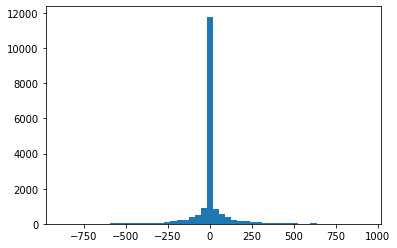

In [116]:
y_pred_naive = y_test[:-1]
y_test_naive = y_test[1:]

err = np.subtract(y_pred_naive, y_test_naive)
plt.hist(err, bins = 50)
mean_err = np.mean(err)
abserr = np.abs(err)
mean_abs_err = np.mean(abserr)
std_abs_err = np.std(abserr)
std_err = np.std(err)
print('Avg error: ' + str(mean_err))
print('Avg absolute error: ' + str(mean_abs_err))
print('Err Std: ' + str(std_err))
print('Abs Err Std: ' + str(std_abs_err))

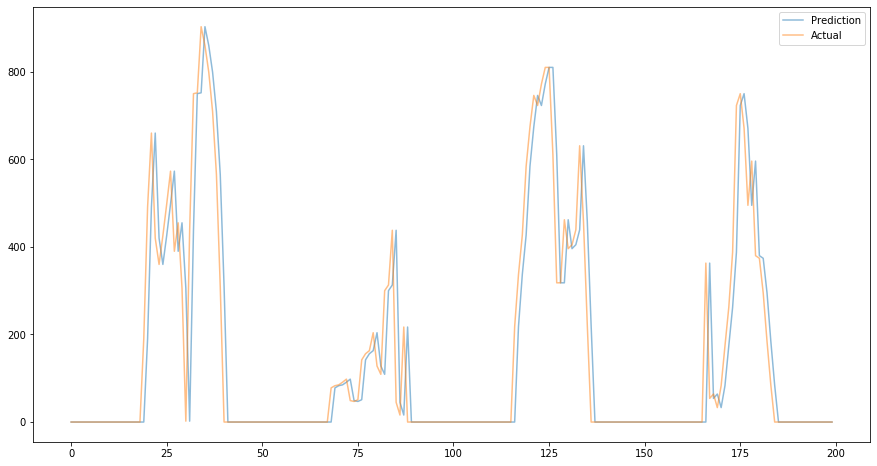

In [117]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
start = 2010
window = 200
plt.plot(y_pred_naive[start:(start+window)],alpha = 0.5)
plt.plot(y_test_naive[start:(start+window)], alpha = 0.5)
plt.legend(['Prediction', 'Actual'])
plt.show()

# FFNN MSELoss function

In [118]:
class Net(torch.nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.relu(self.fc3(x))
net1 = Net(X_train.shape[1])

In [119]:
criterion1 = nn.MSELoss()
optimizer = optim.Adam(net1.parameters(), lr = 0.01)


In [120]:
for epoch in range(1000):
    
    y_pred = net1(X_train_normalized)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion1(y_pred, y_train)
    
    if epoch % 100 == 0:
        print(train_loss)
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

tensor(117670.7578, grad_fn=<MseLossBackward>)
tensor(12156.5439, grad_fn=<MseLossBackward>)
tensor(11864.8301, grad_fn=<MseLossBackward>)
tensor(11734.8672, grad_fn=<MseLossBackward>)
tensor(11701.5225, grad_fn=<MseLossBackward>)
tensor(11696.3125, grad_fn=<MseLossBackward>)
tensor(11694.0908, grad_fn=<MseLossBackward>)
tensor(11690.0127, grad_fn=<MseLossBackward>)
tensor(11687.3818, grad_fn=<MseLossBackward>)
tensor(11684.9922, grad_fn=<MseLossBackward>)


In [121]:
y_test_pred = net1(X_test_normalized)
y_test_pred_np = y_test_pred.detach().numpy()[:,0]

Avg error: -0.08162059021279164
Avg absolute error: 51.748906489750645
Err Std: 103.60829054863936
Abs Err Std: 89.75931823185302


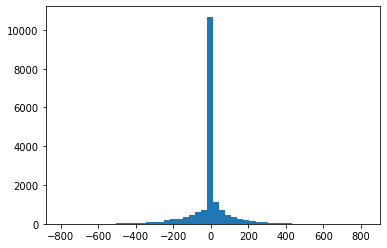

In [122]:
err = np.subtract(y_test_pred_np, y_test)
plt.hist(err, bins = 50)
mean_err = np.mean(err)
abserr = np.abs(err)
mean_abs_err = np.mean(abserr)
std_abs_err = np.std(abserr)
std_err = np.std(err)
print('Avg error: ' + str(mean_err))
print('Avg absolute error: ' + str(mean_abs_err))
print('Err Std: ' + str(std_err))
print('Abs Err Std: ' + str(std_abs_err))

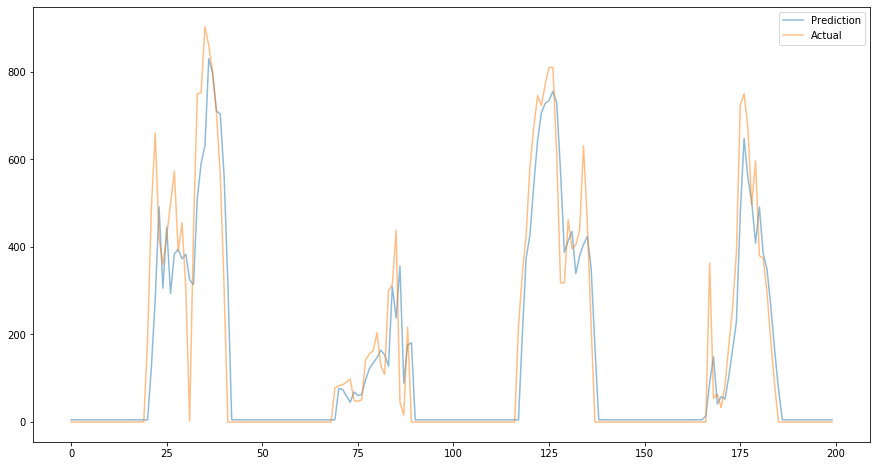

In [123]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
start = 2010
window = 200
plt.plot(y_test_pred_np[start:(start+window)],alpha = 0.5)
plt.plot(y_test[start:(start+window)], alpha = 0.5)
plt.legend(['Prediction', 'Actual'])
plt.show()

# FFNN L1Loss function

In [124]:
net2 = Net(X_train.shape[1])
criterion2 = nn.L1Loss()
optimizer = optim.Adam(net2.parameters(), lr = 0.01)

In [125]:
for epoch in range(1000):
    
    y_pred = net2(X_train_normalized)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion2(y_pred, y_train)
    
    if epoch % 100 == 0:
        print(train_loss)
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

tensor(178.3300, grad_fn=<L1LossBackward>)
tensor(51.7790, grad_fn=<L1LossBackward>)
tensor(50.5215, grad_fn=<L1LossBackward>)
tensor(50.2624, grad_fn=<L1LossBackward>)
tensor(50.0578, grad_fn=<L1LossBackward>)
tensor(49.7405, grad_fn=<L1LossBackward>)
tensor(49.6187, grad_fn=<L1LossBackward>)
tensor(49.5688, grad_fn=<L1LossBackward>)
tensor(49.5475, grad_fn=<L1LossBackward>)
tensor(49.5371, grad_fn=<L1LossBackward>)


In [126]:
y_test_pred = net2(X_test_normalized)
y_test_pred_np = y_test_pred.detach().numpy()[:,0]

Avg error: -8.29121276713209
Avg absolute error: 46.08338055615794
Err Std: 105.81163300688264
Abs Err Std: 95.60945520841229


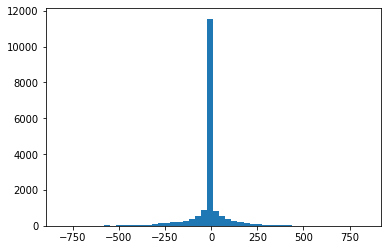

In [127]:
err = np.subtract(y_test_pred_np, y_test)
plt.hist(err, bins = 50)
mean_err = np.mean(err)
abserr = np.abs(err)
mean_abs_err = np.mean(abserr)
std_abs_err = np.std(abserr)
std_err = np.std(err)
print('Avg error: ' + str(mean_err))
print('Avg absolute error: ' + str(mean_abs_err))
print('Err Std: ' + str(std_err))
print('Abs Err Std: ' + str(std_abs_err))

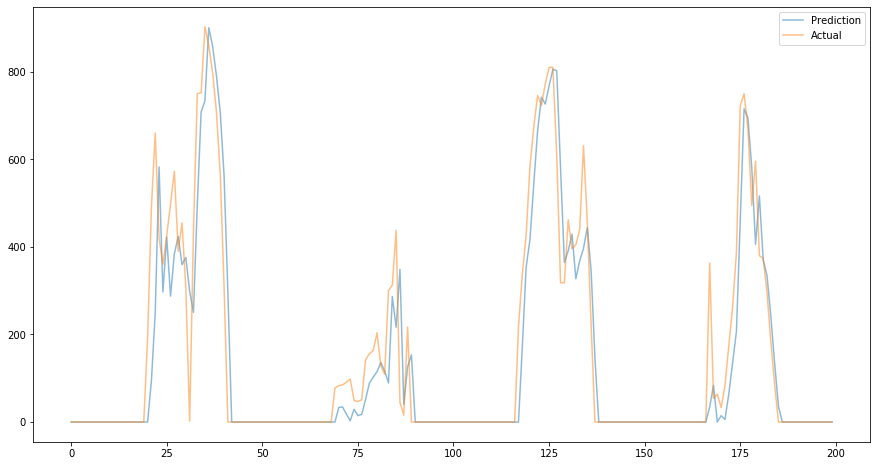

In [128]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
start = 2010
window = 200
plt.plot(y_test_pred_np[start:(start+window)],alpha = 0.5)
plt.plot(y_test[start:(start+window)], alpha = 0.5)
plt.legend(['Prediction', 'Actual'])
plt.show()

# FFNN smooth L1 loss function

In [135]:
net3 = Net(X_train.shape[1])
criterion3 = nn.SmoothL1Loss()
optimizer = optim.Adam(net3.parameters(), lr = 0.01)

In [136]:
for epoch in range(1000):
    
    y_pred = net3(X_train_normalized)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion3(y_pred, y_train)
    
    if epoch % 100 == 0:
        print(train_loss)
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

tensor(178.0204, grad_fn=<SmoothL1LossBackward>)
tensor(51.4006, grad_fn=<SmoothL1LossBackward>)
tensor(50.2609, grad_fn=<SmoothL1LossBackward>)
tensor(49.9733, grad_fn=<SmoothL1LossBackward>)
tensor(49.5632, grad_fn=<SmoothL1LossBackward>)
tensor(49.3653, grad_fn=<SmoothL1LossBackward>)
tensor(49.2942, grad_fn=<SmoothL1LossBackward>)
tensor(49.2598, grad_fn=<SmoothL1LossBackward>)
tensor(49.2435, grad_fn=<SmoothL1LossBackward>)
tensor(49.2433, grad_fn=<SmoothL1LossBackward>)


In [137]:
y_test_pred = net3(X_test_normalized)
y_test_pred_np = y_test_pred.detach().numpy()[:,0]



Avg error: -8.553885516229847
Avg absolute error: 46.05522662360967
Err Std: 105.75269541457172
Abs Err Std: 95.58094813047158


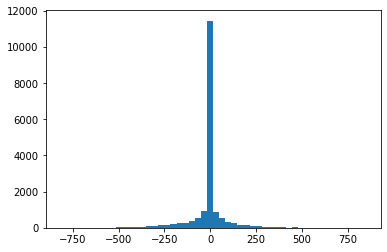

In [138]:
err = np.subtract(y_test_pred_np, y_test)
plt.hist(err, bins = 50)
mean_err = np.mean(err)
abserr = np.abs(err)
mean_abs_err = np.mean(abserr)
std_abs_err = np.std(abserr)
std_err = np.std(err)
print('Avg error: ' + str(mean_err))
print('Avg absolute error: ' + str(mean_abs_err))
print('Err Std: ' + str(std_err))
print('Abs Err Std: ' + str(std_abs_err))

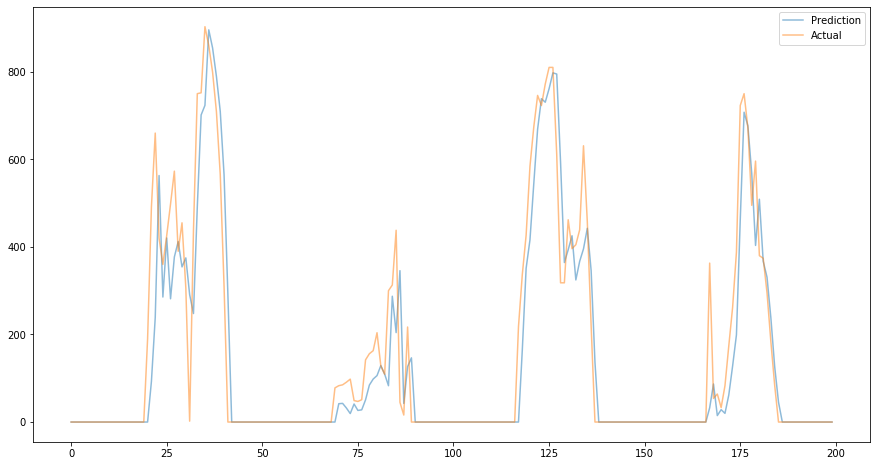

In [139]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
start = 2010
window = 200
plt.plot(y_test_pred_np[start:(start+window)],alpha = 0.5)
plt.plot(y_test[start:(start+window)], alpha = 0.5)
plt.legend(['Prediction', 'Actual'])
plt.show()

# Use t-1 and t-2 from 6 cities

In [198]:
inputs2 = np.concatenate((all_data[1:-1,:], all_data[:-2,:]), axis = 1)
targets2 = all_data[2:,0]

print(inputs2[15:20,:])
print(targets2[15:20])

[[159. 130. 173.   0. 148.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 165. 411.  17. 159. 130. 173.   0. 148.   0.]
 [580. 563.   0. 145. 571. 563.   0.   0.   0. 165. 411.  17.]
 [167.  47.  29.  74. 182. 121. 580. 563.   0. 145. 571. 563.]
 [252.  49.  11.   0. 115.  82. 167.  47.  29.  74. 182. 121.]]
[  0. 580. 167. 252. 116.]


In [199]:
X_train2 = inputs2[:train_length,:]
y_train2 = targets2[:train_length]

X_test2 = inputs2[train_length:,:]
y_test2 = targets2[train_length:]



In [200]:
scaler = MinMaxScaler()

X_train2_normalized = scaler.fit(X_train2)

X_train2_normalized = scaler.transform(X_train2)
X_test2_normalized = scaler.transform(X_test2)




In [201]:
X_train2_normalized = torch.from_numpy(X_train2_normalized).float()
y_train2 = torch.squeeze(torch.from_numpy(y_train2).float())

X_test2_normalized = torch.from_numpy(X_test2_normalized).float()



In [202]:
net4 = Net(X_train2.shape[1])


In [203]:
criterion1 = nn.MSELoss()
optimizer = optim.Adam(net4.parameters(), lr = 0.01)


In [204]:
for epoch in range(1000):
    
    y_pred = net4(X_train2_normalized)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion1(y_pred, y_train2)
    
    if epoch % 100 == 0:
        print(train_loss)
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

tensor(117688.5469, grad_fn=<MseLossBackward>)
tensor(13872.2021, grad_fn=<MseLossBackward>)
tensor(12155.0117, grad_fn=<MseLossBackward>)
tensor(11228.3193, grad_fn=<MseLossBackward>)
tensor(11150.3086, grad_fn=<MseLossBackward>)
tensor(11135.4854, grad_fn=<MseLossBackward>)
tensor(11125.6797, grad_fn=<MseLossBackward>)
tensor(11115.0176, grad_fn=<MseLossBackward>)
tensor(11101.6475, grad_fn=<MseLossBackward>)
tensor(11082.3350, grad_fn=<MseLossBackward>)


In [250]:
y_test_pred = net4(X_test2_normalized)
y_test_pred_np = y_test_pred.detach().numpy()[:,0]

Avg error: 0.25129359187512573
Avg absolute error: 49.755753747328654
Err Std: 101.46472394236176
Abs Err Std: 88.42804036166463


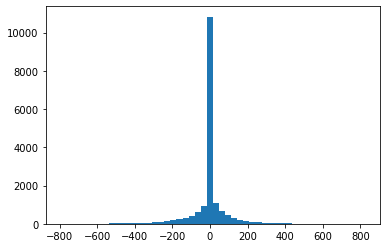

In [251]:
err = np.subtract(y_test_pred_np, y_test2)
plt.hist(err, bins = 50)
mean_err = np.mean(err)
abserr = np.abs(err)
mean_abs_err = np.mean(abserr)
std_abs_err = np.std(abserr)
std_err = np.std(err)
print('Avg error: ' + str(mean_err))
print('Avg absolute error: ' + str(mean_abs_err))
print('Err Std: ' + str(std_err))
print('Abs Err Std: ' + str(std_abs_err))

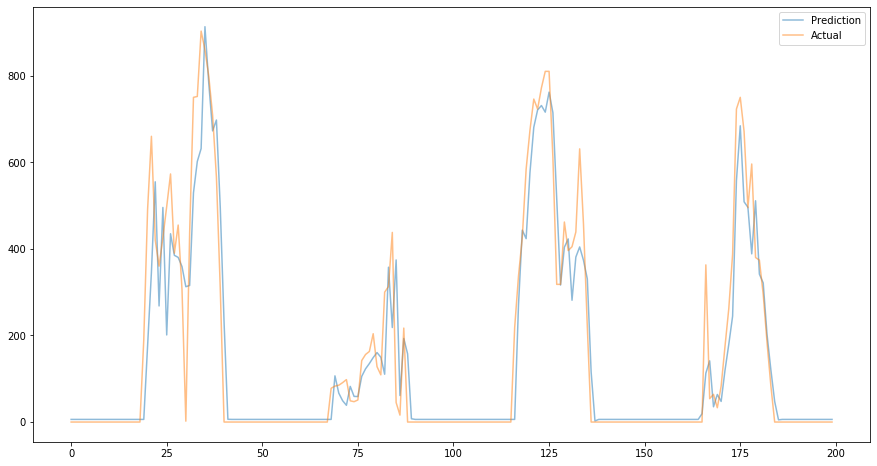

In [252]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
start = 2010
window = 200
plt.plot(y_test_pred_np[start:(start+window)],alpha = 0.5)
plt.plot(y_test2[start:(start+window)], alpha = 0.5)
plt.legend(['Prediction', 'Actual'])
plt.show()

# Use t-1, t-2, t-3, and t-4 from 6 cities


In [239]:
inputs3 = np.concatenate((all_data[3:-1,:], all_data[2:-2,:], all_data[1:-3,:], all_data[:-4,:]), axis = 1)
targets3 = all_data[4:,0]

print(inputs3[15:20,:])
print(targets3[15:20])
print(inputs3.shape)

[[580. 563.   0. 145. 571. 563.   0.   0.   0. 165. 411.  17. 159. 130.
  173.   0. 148.   0.   0.   0.   0.   0.   0.   0.]
 [167.  47.  29.  74. 182. 121. 580. 563.   0. 145. 571. 563.   0.   0.
    0. 165. 411.  17. 159. 130. 173.   0. 148.   0.]
 [252.  49.  11.   0. 115.  82. 167.  47.  29.  74. 182. 121. 580. 563.
    0. 145. 571. 563.   0.   0.   0. 165. 411.  17.]
 [116.  12.  14.   7.  45.  24. 252.  49.  11.   0. 115.  82. 167.  47.
   29.  74. 182. 121. 580. 563.   0. 145. 571. 563.]
 [ 34.   1.  87. 391. 375. 434. 116.  12.  14.   7.  45.  24. 252.  49.
   11.   0. 115.  82. 167.  47.  29.  74. 182. 121.]]
[167. 252. 116.  34. 271.]
(105116, 24)


In [240]:
X_train3 = inputs3[:train_length,:]
y_train3 = targets3[:train_length]

X_test3 = inputs3[train_length:,:]
y_test3 = targets3[train_length:]



In [241]:
scaler = MinMaxScaler()

X_train3_normalized = scaler.fit(X_train3)

X_train3_normalized = scaler.transform(X_train3)
X_test3_normalized = scaler.transform(X_test3)



In [242]:
X_train3_normalized = torch.from_numpy(X_train3_normalized).float()
y_train3 = torch.squeeze(torch.from_numpy(y_train3).float())

X_test3_normalized = torch.from_numpy(X_test3_normalized).float()



In [244]:
net5 = Net(X_train3.shape[1])
print(net5)

Net(
  (fc1): Linear(in_features=24, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [245]:
criterion1 = nn.MSELoss()
optimizer = optim.Adam(net5.parameters(), lr = 0.01)

In [246]:
for epoch in range(1000):
    
    y_pred = net5(X_train3_normalized)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion1(y_pred, y_train3)
    
    if epoch % 100 == 0:
        print(train_loss)
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

tensor(117715.0312, grad_fn=<MseLossBackward>)
tensor(13501.3838, grad_fn=<MseLossBackward>)
tensor(11108.9316, grad_fn=<MseLossBackward>)
tensor(10864.7891, grad_fn=<MseLossBackward>)
tensor(10791.4668, grad_fn=<MseLossBackward>)
tensor(10773.1426, grad_fn=<MseLossBackward>)
tensor(10762.6348, grad_fn=<MseLossBackward>)
tensor(10749.7461, grad_fn=<MseLossBackward>)
tensor(10644.4316, grad_fn=<MseLossBackward>)
tensor(10375.7861, grad_fn=<MseLossBackward>)


In [247]:
y_test_pred = net5(X_test3_normalized)
y_test_pred_np = y_test_pred.detach().numpy()[:,0]

Avg error: -2.4559917461414584
Avg absolute error: 44.58590554359932
Err Std: 98.80827126666364
Abs Err Std: 88.21112964371868


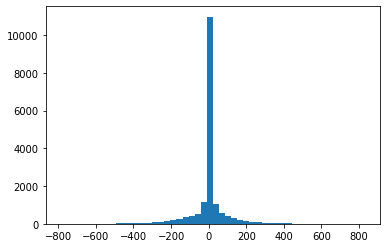

In [248]:
err = np.subtract(y_test_pred_np, y_test3)
plt.hist(err, bins = 50)
mean_err = np.mean(err)
abserr = np.abs(err)
mean_abs_err = np.mean(abserr)
std_abs_err = np.std(abserr)
std_err = np.std(err)
print('Avg error: ' + str(mean_err))
print('Avg absolute error: ' + str(mean_abs_err))
print('Err Std: ' + str(std_err))
print('Abs Err Std: ' + str(std_abs_err))

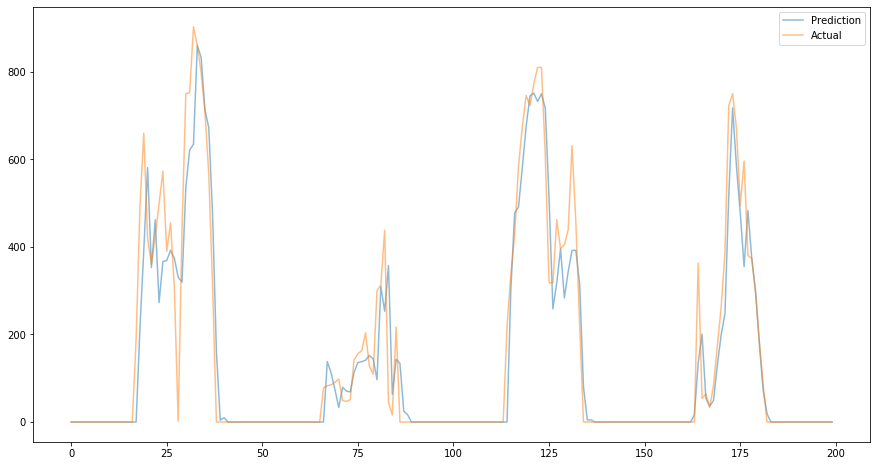

In [249]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
start = 2010
window = 200
plt.plot(y_test_pred_np[start:(start+window)],alpha = 0.5)
plt.plot(y_test3[start:(start+window)], alpha = 0.5)
plt.legend(['Prediction', 'Actual'])
plt.show()